## Aim ##

As part of community contribution we aim to analyze the crime frequency in the districts surrounding Columbia University. As international students, we were very concerned about the safety of the locality we wished to reside in. Our project helps in identifying areas of high crime and thereby help students with their house hunting in NYC. 

## Procedure ##

We begin by first installing geopandas. This library is required to work with geospatial data. 

In [1]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


We then imported all the necassary libraries to visualize our findings. We used seaborn, folium and plotly here.

In [ ]:
import pandas as pd
import numpy as np
import json
import folium
import geopandas as gpd
import branca.colormap as cm

The data we collected from https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i consists of 7.8 million rows. It included all crimes from all the precincts in the city of New York. We only need information from the precincts surrounding Columbia University. We filtered the data this way to get a dataframe having 269k rows.

In [ ]:
df1=pd.read_csv('all years')

In [14]:
len(df1)

269811

The data also had crimes from 1980 but there existed missing values. Moreover, we only wanted to include the last decade in our analysis. This lets us get a much better and accurate idea of the safety of the locality. After excluding all the data before 2009, we were left with 189k rows.

In [15]:
df1=df1[df1['CMPLNT_FR_DT']>2009]

In [16]:
len(df1)

189398

In order to plot the data on a chloropleth map, we need the geographical polygons describing the outline of each precinct. We obtained a geojson file from https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz for this purpose. Again, we only get the precincts we require which are 24, 28, 26 and 30. We only keep the precinct and geometry column for simplicity

In [61]:
stk_list=['24','28','26','30']
nil = gpd.read_file('Police Precincts.geojson')
nil=nil[nil['precinct'].isin(stk_list)]
nil

,precinct,shape_area,shape_leng,geometry
16,24,25479873.3684,20706.9190759,"MULTIPOLYGON (((-73.95965 40.80116, -73.95856 ..."
18,26,23836010.5268,23938.4964876,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ..."
19,28,15289544.596,17098.9870878,"MULTIPOLYGON (((-73.94132 40.80771, -73.94177 ..."
20,30,18845037.7959,21645.146297,"MULTIPOLYGON (((-73.94017 40.83038, -73.93963 ..."


In [62]:
nil=nil[['precinct','geometry']]

We grouped the crimes in our dataframe by precinct and then took a count. We also substituted the crime column for each precinct by each precincts contribution to the total crime in terms of a percentage value.

In [63]:
x=df1.groupby('ADDR_PCT_CD').size().to_frame()
x.reset_index(inplace=True)
x=x.rename(columns={0: "crimes",'ADDR_PCT_CD':'precinct'})
x['crimes']=x['crimes']/x['crimes'].sum()*100

To center our map in our desired region, we calculate the centroid of all the regions. 

In [64]:
x_map=nil.centroid.x.mean()
y_map=nil.centroid.y.mean()
print(x_map,y_map)

-73.95739234564192 40.80957562817518


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


We then add our crime values to the dataset with the geospatial data.

In [65]:
nil['crimes']=x['crimes'].values

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Given below is an example of a polygon used to create the Chloropleth map.

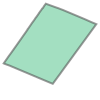

In [66]:
nil['geometry'][16]

The code below creates the map into which we add our data to create the Chloropleth map.

In [71]:
mymap = folium.Map(location=[y_map, x_map], zoom_start=14,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
mymap

The map is then generated coloring each precinct by the degree of crime

In [72]:
myscale = (nil['crimes'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
mymap.choropleth(
 geo_data=nil,
 name='Choropleth',
 data=nil,
 columns=['precinct','crimes'],
 key_on="feature.properties.precinct",
 fill_color='YlOrRd',
 threshold_scale=myscale,
 fill_opacity=1,
 line_opacity='Crime %',
 smooth_factor=0
)
mymap

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The map above is not particulary descriptive. We cannot really isolate each precinct and neither get a clear crime % value. To get a better visualization, we made the map interactive. When the user's cursor hovers over a region, they can see the precinct number as well as the crime percentage of the area.

In [73]:
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    nil,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['precinct','crimes'],
        aliases=['Precinct: ','Crime %: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mymap.add_child(NIL)
mymap.keep_in_front(NIL)
folium.LayerControl().add_to(mymap)
mymap